In [1]:
import tqdm
import pickle
import warnings
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from pk.utils import threshold_analysis, heatmap
from pk.file_handling import read_pk_dataset, read_pk_dataset_with_split
from pk.preprocessing import calc_high_corr_feats, calc_low_variance_feats, scale_columns
from pk.features import morgan_fingerprint
from pk.model_selection import CrossValidator
from pk.model_comparison import compare_models_optimizers_on_split, hypothesis_test_multiple_comparison

from rdkit import Chem
from rdkit.Chem import PandasTools

tqdm.tqdm.pandas()

In [2]:
DATA_PATH = '../data/updatedPK.csv'

TRAIN_PATH = '../data/pk_60_40_training_seed42.csv'
VAL_PATH = '../data/pk_60_40_cv_seed42.csv'
TEST_PATH = '../data/pk_60_40_et_seed42.csv'

MODE = 'bin_class'

TEST_SIZE = 0.2
CROSS_VALIDATION_K = 5
FP_NBITS = 64
CORR_THRESH = 0.95
VAR_THRESH = 0.1
RANDOM_STATE = 42
RANDOM_SEED = 0

assert MODE in ('bin_class', 'reg', 'cat_class'), \
    f"MODE, '{MODE}' is invalid."

np.random.seed(RANDOM_SEED)

### Read Data

Shape of dataset = (190, 209)
Columns with null values = ['Cmpd Name']
Label distribution in train set:
1    0.505263
0    0.494737
Name: AUC_bin, dtype: float64


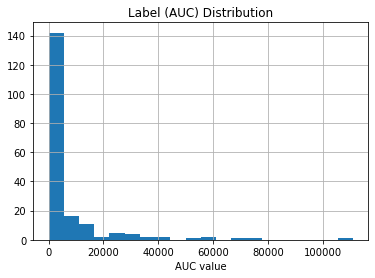

Shape of train data = (114, 4177)
Columns with null values = []
Shape of test data = (38, 4177)
Columns with null values = []
Shape of validation data = (38, 4177)
Columns with null values = []
Label distribution in train set:
1    0.508772
0    0.491228
Name: AUC_bin, dtype: float64


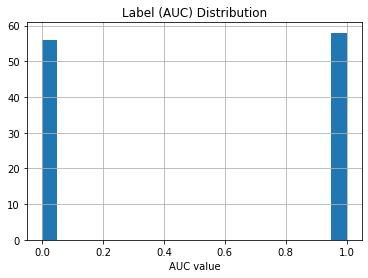

In [3]:
df_base, remove_cols = read_pk_dataset(DATA_PATH, mode=MODE)
df_trn, df_val, df_tst, _ = read_pk_dataset_with_split(TRAIN_PATH, TEST_PATH, val_path=VAL_PATH, mode=MODE, ycol='AUC1')

def predefined_split(df, split):
    df_trn, df_val, df_tst = split
    
    df_train = df[df['mol'].isin(df_trn['mol'].values)]
    df_valid = df[df['mol'].isin(df_val['mol'].values)]
    df_test = df[df['mol'].isin(df_tst['mol'].values)]
    
    df_train = pd.concat([df_train, df_valid])
    
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    assert set(df_test['mol']) == set(df_tst['mol'])
    assert set(df_train['mol']) == set(df_trn['mol']).union(set(df_val['mol']))
    assert not df_train['mol'].isnull().sum() and not df_test['mol'].isnull().sum()
    assert df_train['mol'].is_unique and df_test['mol'].is_unique
    
    return df_train, df_test

df_train, df_test = predefined_split(df_base, [df_trn, df_val, df_tst])

### Pipeline 1 (Khadija's Work)

In [4]:
X_trn_p1, y_trn_p1 = df_trn.drop(['mol', 'AUC', 'AUC_bin'], axis=1), df_trn['AUC_bin']
X_val_p1, y_val_p1 = df_val.drop(['mol', 'AUC', 'AUC_bin'], axis=1), df_val['AUC_bin']
X_tst_p1, y_tst_p1 = df_tst.drop(['mol', 'AUC', 'AUC_bin'], axis=1), df_tst['AUC_bin']

In [5]:
models = [RandomForestClassifier, XGBClassifier, LGBMClassifier, CatBoostClassifier]

p1_trained_models, p1_test_metrics = \
    compare_models_optimizers_on_split(models, 
                                       X_trn_p1, y_trn_p1, 
                                       X_tst_p1, y_tst_p1, 
                                       X_val=X_val_p1, y_val=y_val_p1,
                                       random_state=RANDOM_STATE,
                                       random_seed=RANDOM_SEED,
                                       max_evals=2,
                                       val_mode='k_fold_random_split',
                                       pipeline_suffix='P1')

Training models using 'hyperopt'.

Optimizing: RandomForestClassifier.
100%|██████████| 2/2 [00:10<00:00,  5.00s/trial, best loss: -0.814222]
Optimizing: XGBClassifier.
100%|██████████| 2/2 [00:11<00:00,  5.74s/trial, best loss: -0.8036659999999999]
Optimizing: LGBMClassifier.
100%|██████████| 2/2 [00:02<00:00,  1.16s/trial, best loss: -0.85111]
Optimizing: CatBoostClassifier.
100%|██████████| 2/2 [00:19<00:00,  9.69s/trial, best loss: -0.8448340000000001]

Model: RandomForestClassifier | Test auroc: 88.643
Model: XGBClassifier | Test auroc: 89.474
Model: LGBMClassifier | Test auroc: 86.42699999999999
Model: CatBoostClassifier | Test auroc: 86.70400000000001

Optimizer time = 65.265 s.

Training models using 'optuna'.

Optimizing: RandomForestClassifier.



Optimizing: XGBClassifier.



Optimizing: LGBMClassifier.



Optimizing: CatBoostClassifier.




Model: RandomForestClassifier | Test auroc: 90.859
Model: XGBClassifier | Test auroc: 87.535
Model: LGBMClassifier | Test auroc: 87.535
Model: CatBoostClassifier | Test auroc: 89.474

Optimizer time = 84.004 s.

Training models using 'random_search'.

Optimizing: RandomForestClassifier.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
  Time taken = 12s
Optimizing: XGBClassifier.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
  Time taken = 13s
Optimizing: LGBMClassifier.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
  Time taken = 2s
Optimizing: CatBoostClassifier.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
  Time taken = 32s

Model: RandomForestClassifier | Test auroc: 88.92
Model: XGBClassifier | Test auroc: 89.474
Model: LGBMClassifier | Test auroc: 50.0
Model: CatBoostClassifier | Test auroc: 88.92

Optimizer time = 124.596 s.

Total time = 273.866 s.


In [6]:
with open('../data/pipeline_1_trained_models.pkl', 'wb') as f:
    pickle.dump(
        {
            'trained_models': p1_trained_models,
            'test_metrics': p1_test_metrics
        }, 
        f
    )

with open('../data/pipeline_1_trained_models.pkl', 'rb') as f:
    pipeline_1 = pickle.load(f)
    
p1_trained_models, p1_test_metrics = pipeline_1['trained_models'], pipeline_1['test_metrics']

### Pipeline 2 (Vedang's Work)

In [7]:
class FeatureEngineeringPipeline:
    
    def __init__(self, corr_thresh, var_thresh, fp_n_bits):
        self.corr_thresh = corr_thresh
        self.var_thresh = var_thresh
        self.fp_n_bits = fp_n_bits
        
        self.ycol = None
        self.scaler = None
        self.cross_validator = None  # Not really used during inference
        self.final_col_set = None
        self.is_fit = False
        
    def fit_transform(self, df_train, df_test, remove_cols, ycol='AUC_bin'):
        warnings.filterwarnings('ignore')
        
        # Create a copy to avoid changing original data
        df_trn, df_tst = df_train.copy(), df_test.copy()
    
        # Remove high correlation features
        high_corr_feats = calc_high_corr_feats(df_train, 
                                               remove_cols, 
                                               threshold=self.corr_thresh)
        remove_cols.update(high_corr_feats)

        # Remove low variance features
        low_var_feats = calc_low_variance_feats(df_train,
                                                remove_cols,
                                                threshold=self.var_thresh)
        remove_cols.update(low_var_feats)

        # Scale columns
        df_train_scaled, df_test_scaled, scaler = scale_columns(df_train, 
                                                                df_test, 
                                                                list(remove_cols))

        # Add morgan fingerprints
        df_train_scaled = morgan_fingerprint(df_train_scaled, n_bits=self.fp_n_bits)
        df_test_scaled = morgan_fingerprint(df_test_scaled, n_bits=self.fp_n_bits)

        # Create train and test sets
        X_train, y_train = df_train_scaled.drop(remove_cols, axis=1), df_train_scaled[ycol]
        X_test, y_test = df_test_scaled.drop(remove_cols, axis=1), df_test_scaled[ycol]

        # Remove zero importance features
        cv = CrossValidator()
        cv.fit(X_train, y_train)
        
        remove_cols.update(cv.zero_imp_feats())
        X_train.drop(cv.zero_imp_feats(), axis=1, inplace=True)
        X_test.drop(cv.zero_imp_feats(), axis=1, inplace=True)
        
        # Set the is_fit flag
        self.is_fit = True
        
        # Save objects to memory
        self.ycol = ycol
        self.scaler = scaler
        self.cross_validator = cv
        self.final_col_set = set(X_train.columns)

        return X_train, y_train, X_test, y_test, remove_cols
    
    def transform(self, df_infer):
        if not self.is_fit:
            raise ValueError(f"Object is not fit yet!")
            
        if self.ycol not in df_infer.columns:
            warnings.warn(f"Label column, {self.ycol} not present in inference set.")
            
        # Copy data to avoid changing it
        df = df_infer.copy()
        
        # Add morgan fingerprint
        df = morgan_fingerprint(df, n_bits=self.fp_n_bits)
        
        # Check if all columns are present
        if self.final_col_set - set(df.columns):
            raise ValueError(f"Inference set doesn't have the following columns: {self.final_col_set - set(df_infer.columns)}.")
        
        to_scale = set(self.scaler.feature_names_in_).intersection(self.final_col_set)
        scale_extra = set(self.scaler.feature_names_in_) - self.final_col_set
        
        df_scale, df_not_scale = df[to_scale], df[self.final_col_set - to_scale]
        
        for col in scale_extra:
            df_scale[col] = 0.
            
        scale_cols = df_scale.columns
        
        df_scaled = self.scaler.transform(df_scale)
        df_scaled = pd.DataFrame(df_scaled, columns=scale_cols)
        
        df_scaled.drop(scale_extra, axis=1, inplace=True)
        
        df_combined = pd.concat([df_scaled, df_not_scale], axis=1)
        
        return df_combined

In [8]:
fep_2 = FeatureEngineeringPipeline(corr_thresh=CORR_THRESH, var_thresh=VAR_THRESH, fp_n_bits=FP_NBITS)

X_train, y_train, X_test, y_test, remove_cols = fep_2.fit_transform(df_train, df_test, remove_cols)

X_trn_p2, X_val_p2, y_trn_p2, y_val_p2 = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)
X_tst_p2, y_tst_p2 = X_test.copy(), y_test.copy()

In [9]:
models = [RandomForestClassifier, XGBClassifier, LGBMClassifier, CatBoostClassifier]

p2_trained_models, p2_test_metrics = \
    compare_models_optimizers_on_split(models, 
                                       X_trn_p2, y_trn_p2, 
                                       X_tst_p2, y_tst_p2, 
                                       X_val=X_val_p2, y_val=y_val_p2,
                                       random_state=RANDOM_STATE,
                                       random_seed=RANDOM_SEED,
                                       max_evals=20,
                                       val_mode='k_fold_random_split',
                                       pipeline_suffix='P2')

Training models using 'hyperopt'.

Optimizing: RandomForestClassifier.
100%|██████████| 20/20 [02:43<00:00,  8.19s/trial, best loss: -0.8107219999999999]
Optimizing: XGBClassifier.
100%|██████████| 20/20 [00:14<00:00,  1.40trial/s, best loss: -0.817332]          
Optimizing: LGBMClassifier.
100%|██████████| 20/20 [00:11<00:00,  1.77trial/s, best loss: -0.8421119999999999]
Optimizing: CatBoostClassifier.
Type: CatBoost
Hyperopt space = {'iterations': <hyperopt.pyll.base.Apply object at 0x7f019bb1efd0>, 'depth': <hyperopt.pyll.base.Apply object at 0x7f0199e51400>, 'learning_rate': <hyperopt.pyll.base.Apply object at 0x7f0199e51520>, 'l2_leaf_reg': <hyperopt.pyll.base.Apply object at 0x7f0199e51790>, 'border_count': <hyperopt.pyll.base.Apply object at 0x7f0199e51670>, 'bagging_temperature': <hyperopt.pyll.base.Apply object at 0x7f019013da00>, 'random_strength': <hyperopt.pyll.base.Apply object at 0x7f019013db50>, 'verbose': False}
Type: CatBoost
100%|██████████| 20/20 [02:27<00:00,  7.40s


Optimizing: XGBClassifier.



Optimizing: LGBMClassifier.



Optimizing: CatBoostClassifier.




Model: RandomForestClassifier | Test auroc: 93.075
Model: XGBClassifier | Test auroc: 86.981
Model: LGBMClassifier | Test auroc: 87.535
Model: CatBoostClassifier | Test auroc: 86.70400000000001

Optimizer time = 409.512 s.

Training models using 'random_search'.

Optimizing: RandomForestClassifier.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
  Time taken = 5s
Optimizing: XGBClassifier.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
  Time taken = 2s
Optimizing: LGBMClassifier.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
  Time taken = 1s
Optimizing: CatBoostClassifier.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
  Time taken = 25s

Model: RandomForestClassifier | Test auroc: 91.136
Model: XGBClassifier | Test auroc: 87.258
Model: LGBMClassifier | Test auroc: 50.0
Model: CatBoostClassifier | Test auroc: 89.751

Optimizer time = 82.008 s.

Total time = 852.153 s.


In [11]:
with open('../data/pipeline_2_trained_models.pkl', 'wb') as f:
    pickle.dump(
        {
            'trained_models': p2_trained_models,
            'test_metrics': p2_test_metrics
        },
        f
    )

with open('../data/pipeline_2_trained_models.pkl', 'rb') as f:
    pipeline_2 = pickle.load(f)
    
p2_trained_models, p2_test_metrics = pipeline_2['trained_models'], pipeline_2['test_metrics']

In [12]:
trained_models = {}
trained_models.update(p1_trained_models)
trained_models.update(p2_trained_models)

test_metrics = pd.concat([p1_test_metrics, p2_test_metrics], axis=0).sort_values('auroc', axis=0, ascending=False)
test_metrics.set_index('model', inplace=True)

### Model Comparison

In [12]:
n_models = 5

estimators = {}
for i, m in enumerate(list(test_metrics.index)):
    if i == n_models:
        break
    estimators[m] = trained_models[m]
    
predictions = []
for name, est in estimators.items():
    if 'P1' in name:
        predictions.append(est.predict(X_tst_p1))
    elif 'P2' in name:
        predictions.append(est.predict(X_tst_p2))
    else:
        raise NameError(f"Estimator '{name}' incorrectly named!")
        
hypothesis_test_multiple_comparison(estimators, predictions, None, y_tst_p2)


Cochran's Q-Test.
Q: 43.394
p-value: 0.000
p-value < alpha (0.05) => Reject H0.

Conducting post-hoc tests.

Combination: ('RandomForestClassifier/optuna/P2', 'RandomForestClassifier/optuna/P1'),
	 p-value = 0.0

Combination: ('RandomForestClassifier/optuna/P2', 'CatBoostClassifier/random_search/P2'),
	 p-value = nan

Combination: ('RandomForestClassifier/random_search/P2', 'RandomForestClassifier/optuna/P1'),
	 p-value = 0.001

Combination: ('RandomForestClassifier/optuna/P1', 'CatBoostClassifier/random_search/P2'),
	 p-value = 0.0



,Model 1,Model 2,chi2,p,alpha,Reject H0
0,RandomForestClassifier/optuna/P2,RandomForestClassifier/random_search/P2,1.000000,0.317311,0.005,False
1,RandomForestClassifier/optuna/P2,RandomForestClassifier/optuna/P1,14.000000,0.000183,0.005,True
2,RandomForestClassifier/optuna/P2,RandomForestClassifier/hyperopt/P2,2.000000,0.157299,0.005,False
3,RandomForestClassifier/optuna/P2,CatBoostClassifier/random_search/P2,NaN,NaN,0.005,True
4,RandomForestClassifier/random_search/P2,RandomForestClassifier/optuna/P1,11.266667,0.000789,0.005,True
5,RandomForestClassifier/random_search/P2,RandomForestClassifier/hyperopt/P2,1.000000,0.317311,0.005,False
6,RandomForestClassifier/random_search/P2,CatBoostClassifier/random_search/P2,1.000000,0.317311,0.005,False
7,RandomForestClassifier/optuna/P1,RandomForestClassifier/hyperopt/P2,9.000000,0.002700,0.005,False
8,RandomForestClassifier/optuna/P1,CatBoostClassifier/random_search/P2,14.000000,0.000183,0.005,True
9,RandomForestClassifier/hyperopt/P2,CatBoostClassifier/random_search/P2,2.000000,0.157299,0.005,False


### Inference on Test Set

In [15]:
df_et = pd.read_csv('../data/external_test.csv')
df_et.rename({'SMILES': 'mol'}, axis=1, inplace=True)

X_et_2 = fep_2.transform(df_et)
assert set(X_trn_p2.columns) == set(X_et_2.columns)

In [16]:
def external_test_inference(trained_models, test_metrics, df_et, pipeline_features, threshold_type='best_f1', n_models=5, top_k=100, plot_heatmap=True):
    """
    Parameters
    ----------
    threshold_type: str
        One of 'best_f1', 'best_precision', 'best_j'
    """

    top_models = test_metrics.head(n_models).index.values
    overlaps = np.zeros((n_models, n_models))

    et_results = df_et[['mol']].copy()
    et_sorted_preds = pd.DataFrame()

    models_to_idx = {}
    for i, m in enumerate(top_models):
        models_to_idx[m] = i
        pipeline = 'P1' if 'P1' in m else 'P2'

        # TODO: remove this
        if pipeline == 'P1':
            continue

        et_results[m] = trained_models[m].predict_proba(pipeline_features[pipeline])[:, 1]
        m_scores = trained_models[m].predict_proba(pipeline_features[pipeline])[:, 1]
        et_sorted_preds[m] = df_et['mol'].values[np.argsort(m_scores)]
                
    et_results.set_index('mol', inplace=True)
    
    top_n_sorted_preds = et_sorted_preds.head(top_k)

    for (m1, m2) in itertools.combinations(et_sorted_preds.columns, 2):
        overlap = len(set(top_n_sorted_preds[m1]).intersection(set(top_n_sorted_preds[m2])))
        overlaps[models_to_idx[m1], models_to_idx[m2]] = overlap
        overlaps[models_to_idx[m2], models_to_idx[m1]] = overlap
        
    # overlaps /= top_k

    if plot_heatmap:
        fig, ax = plt.subplots(figsize=(7, 5))

        _, _ = heatmap(overlaps, top_models, top_models, ax=ax,
                       cmap="Reds", cbarlabel=f"top-{top_k} overlap")

        ax.set_title(f"Top {top_k} overlap between {n_models} best models")
        fig.tight_layout()
        plt.show()
        
    return et_results, et_sorted_preds

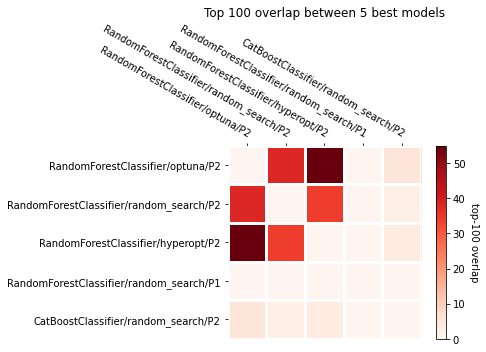

In [17]:
et_results, et_sorted_preds = external_test_inference(trained_models, test_metrics, df_et, {'P2': X_et_2}, plot_heatmap=True)

#### Assumption 1: Probabilities are a mixture of Gaussians

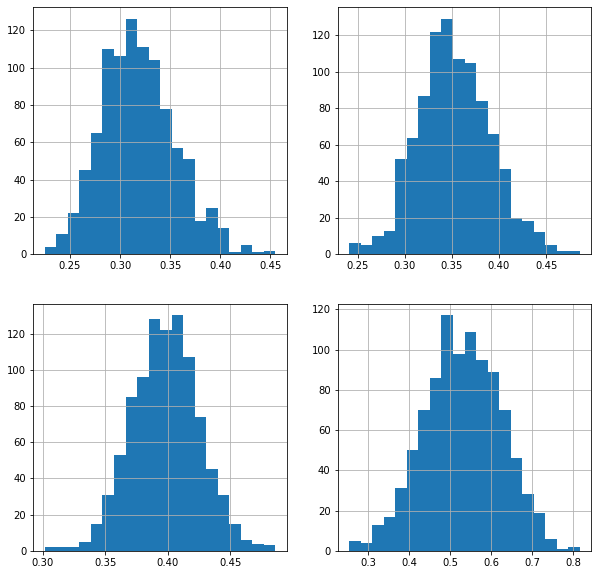

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

et_results['RandomForestClassifier/optuna/P2'].hist(bins=20, ax=axes[0][0])
et_results['RandomForestClassifier/random_search/P2'].hist(bins=20, ax=axes[0][1])
et_results['RandomForestClassifier/hyperopt/P2'].hist(bins=20, ax=axes[1][0])
et_results['CatBoostClassifier/random_search/P2'].hist(bins=20, ax=axes[1][1])

plt.show()

Eyeballing, we see that this is probably not true.

#### Assumption 2: Probabilities follow a normal distribution

The strategy could be to choose the 95th percentile in the distribution.

In [114]:
revised_thresh

0.35522941285698617

In [128]:
revised_thresh = {}
model_names = [col for col in et_results if col != 'mol']

for col in model_names:
    q95 = et_results[col].quantile(0.95)
    best_prec_thresh = test_metrics.loc[col, 'thresh_values']['best_f1_thresh']
    
    if q95 > best_prec_thresh:
        revised_thresh[col] = best_prec_thresh
    else:
        revised_thresh[col] = q95
    
for col in model_names:
    master[col + '_pred'] = master[col].apply(lambda x: int(x >= revised_thresh[col]))

In [129]:
revised_thresh

{'RandomForestClassifier/optuna/P2': 0.3860502577319588,
 'RandomForestClassifier/random_search/P2': 0.42066935286935286,
 'RandomForestClassifier/hyperopt/P2': 0.44301239291431094,
 'CatBoostClassifier/random_search/P2': 0.35522941285698617}

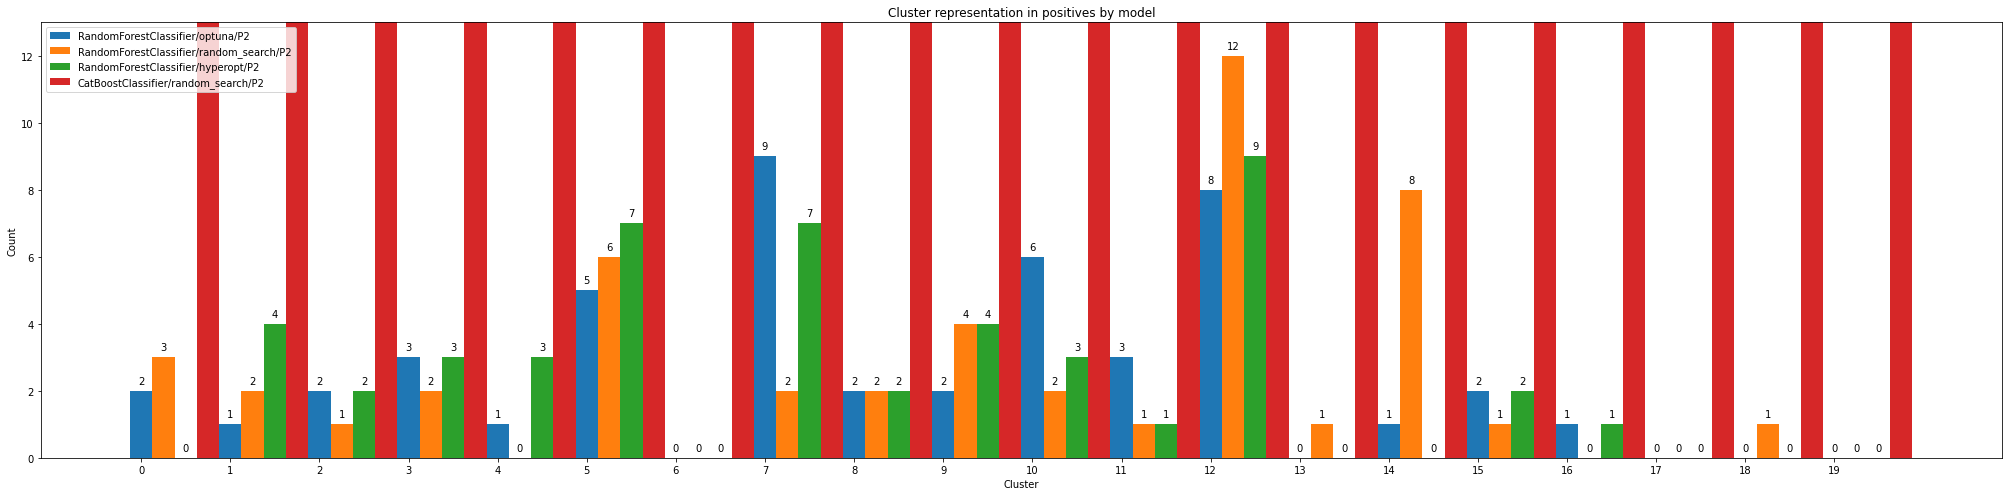

In [131]:
unique_clusters = sorted(master['Cluster'].unique())
unique_clusters

cc_by_model = {}
for col in model_names:
    val_counts = dict(master[master[col + '_pred'] == 1]['Cluster'].value_counts())
    cluster_counts = list({k: val_counts.get(k, 0) for k in unique_clusters}.values())
    cc_by_model[col] = cluster_counts
    
x = np.arange(len(unique_clusters))  # the label locations
width = 0.25  # the width of the bars
multiplier = 1

fig, ax = plt.subplots(layout='tight', figsize=(28, 7))

for attribute, measurement in cc_by_model.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=5)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Cluster representation in positives by model')
ax.set_xticks(x + width, unique_clusters)
ax.set_xlabel('Cluster')
ax.legend(loc='upper left')
ax.set_ylim(0, 13)

plt.show()

In [132]:
thresh_df = pd.DataFrame(list(revised_thresh.items()), columns=['Model', 'Threshold'])
thresh_df['Threshold'] = thresh_df['Threshold'].apply(lambda x: np.round(x, 5))
thresh_df

,Model,Threshold
0,RandomForestClassifier/optuna/P2,0.38605
1,RandomForestClassifier/random_search/P2,0.42067
2,RandomForestClassifier/hyperopt/P2,0.44301
3,CatBoostClassifier/random_search/P2,0.35523


In [133]:
test_metrics

,auroc,lb,ub,thresh_values
model,,,,
RandomForestClassifier/optuna/P2,93.075,0.0,100.0,"{'best_f1_thresh': 0.5344716494845361, 'best_p..."
RandomForestClassifier/random_search/P2,91.136,0.0,100.0,"{'best_f1_thresh': 0.49800086580086567, 'best_..."
RandomForestClassifier/optuna/P1,91.136,0.0,100.0,"{'best_f1_thresh': 0.6469157801892119, 'best_p..."
RandomForestClassifier/hyperopt/P2,90.859,0.0,100.0,"{'best_f1_thresh': 0.5025820155903867, 'best_p..."
CatBoostClassifier/random_search/P2,89.751,0.0,100.0,"{'best_f1_thresh': 0.35522941285698617, 'best_..."
XGBClassifier/random_search/P1,89.474,0.0,100.0,"{'best_f1_thresh': 0.5024372339248657, 'best_p..."
XGBClassifier/hyperopt/P1,89.474,0.0,100.0,"{'best_f1_thresh': 0.5129990577697754, 'best_p..."
CatBoostClassifier/random_search/P1,88.92,0.0,100.0,"{'best_f1_thresh': 0.5583078615961959, 'best_p..."
RandomForestClassifier/random_search/P1,88.92,0.0,100.0,"{'best_f1_thresh': 0.5408569058736242, 'best_p..."


In [134]:
master_sel_cols = ['Molecule Index', 'Molecule Id', 'SMILES', 'molStripped', 'Cluster']
master_sel_cols += model_names
master_sel_cols += [col + '_pred' for col in model_names]

master[master_sel_cols].to_csv('../data/master_top_95p_mar_23.csv')
thresh_df.to_csv('../data/master_top_95p_mar_23_thresholds.csv')

In [17]:
class ScoringFunction:
    
    def __init__(self, test_metrics):
        self.test_metrics = test_metrics

    def score_molecule(self, row):
        score = 0
        for model in list(row.keys()):
            score += self.test_metrics.loc[model]['auroc']*row[model]

        return round(score, 3)

def predict_top_k_molecules(et_results, test_metrics, strategy='score'):
    
    scaler = MinMaxScaler()
    
    idx = et_results.index
    et_results_scaled = pd.DataFrame(scaler.fit_transform(et_results.copy()), columns=et_results.columns)
    et_results_scaled['mol'] = list(idx)
    et_results_scaled.set_index('mol', inplace=True)
    
    if strategy == 'score':
        scorer = ScoringFunction(test_metrics)
        et_results_scaled['score'] = et_results_scaled.apply(scorer.score_molecule, axis=1)
        et_results_scaled.sort_values('score', axis=0, ascending=False, inplace=True)
    
    elif strategy == 'sort':
        et_results_scaled.sort_values(
            [col for col in test_metrics.index if col in set(et_results.columns)],
            axis=0,
            ascending=False,
            inplace=True)
        et_results_scaled['score'] = range(1, et_results_scaled.shape[0]+1, 1)
        
    et_results_scaled.reset_index(drop=False, inplace=True)
    et_results_scaled['ROMol'] = et_results_scaled['mol'].apply(lambda x: Chem.MolFromSmiles(x))

    return et_results_scaled

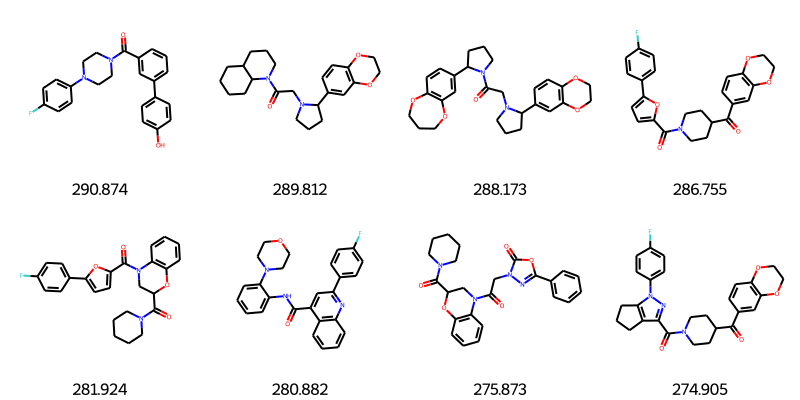

In [18]:
et_preds_scored = predict_top_k_molecules(et_results, test_metrics, strategy='score')
PandasTools.FrameToGridImage(et_preds_scored.head(8), legendsCol="score", molsPerRow=4)

In [19]:
et_preds_scored.to_csv('../data/et_preds_scored_p2.csv')

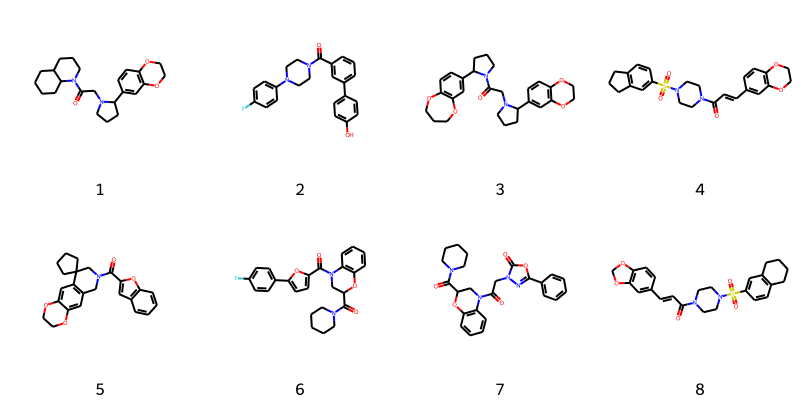

In [20]:
et_preds_sorted = predict_top_k_molecules(et_results, test_metrics, strategy='sort')
PandasTools.FrameToGridImage(et_preds_sorted.head(8), legendsCol="score", molsPerRow=4)

In [21]:
et_preds_sorted.to_csv('../data/et_preds_sorted_p2.csv')

In [22]:
et_results

,RandomForestClassifier/optuna/P2,RandomForestClassifier/random_search/P2,RandomForestClassifier/hyperopt/P2,CatBoostClassifier/random_search/P2
mol,,,,
O=C(Nc1c(Cc2ccccc2)cccc1)C1CCN(c2ncnc3sc4c(c23)CCCC4)CC1,0.367790,0.398114,0.438442,0.420543
O=C1C(=CNN2C(=O)c3c(sc4c3CCCC4)N=C2)CCCC1=Cc1ccccc1,0.382323,0.362193,0.426280,0.360764
Clc1ccc(-c2nc3c(c(C(=O)OCC4=Nc5sc6c(c5C(=O)N4)CCCC6)c2)cccc3)cc1,0.329463,0.405095,0.415577,0.550563
Fc1ccc(C(N2CCN(CC3=Nc4sc5c(c4C(=O)N3)CCC5)CC2)c2ccc(F)cc2)cc1,0.378825,0.448466,0.429216,0.425276
O=C1NC(c2c3c(nc(-c4ccccc4)c2)cccc3)=Nc2sc3c(c12)CCCC3,0.347723,0.382107,0.398629,0.481232
...,...,...,...,...
Clc1cc2nc(N3C(c4sccc4)CC(c4sccc4)=N3)nc(-c3ccccc3)c2cc1,0.304756,0.386098,0.421323,0.413136
Clc1cc2c(-c3ccccc3)nc(N3C(c4c(C)cccc4)CC(c4cc(OC)ccc4)=N3)nc2cc1,0.290488,0.390352,0.392658,0.513098
Clc1cc2c(-c3ccccc3)nc(N3C(c4ccc(OCC)cc4)CC(c4sccc4)=N3)nc2cc1,0.259303,0.317015,0.394699,0.430953


In [20]:
master = pd.read_csv('../data/KasADockedTop1000_Predictions Master_JSFedit030423.csv')

In [21]:
et_results.reset_index(drop=False, inplace=True)

In [22]:
master.shape, et_results.shape

((956, 21), (956, 5))

In [25]:
# master_2 = pd.read_csv('../data/master_top_95p_VW032223mar_22.csv')

In [42]:
master['SMILES'].value_counts()

O=C(NC(Cc1ccccc1)c1[nH]c2c(n1)cccc2)C1CN(c2cc3OCCOc3cc2)C(=O)C1     2
O=C(Nc1c(-c2ccccc2)cccc1)COC(=O)C1C(C(=O)N2c3c(cccc3)CC2)CCCC1      1
O=C(NCc1c(-c2ccccc2)nn(Cc2ccccc2)c1)c1cc2N=C3N(C(=O)c2cc1)CCC3      1
Clc1cc(CN2CCN(C(=O)c3c4c(C)noc4nc(-c4ccccc4)c3)CC2)ccc1             1
Clc1ccc(-c2nc3c(c(C(=O)N4CCN(c5ccc(C(=O)C)cc5)CC4)c2)cccc3)cc1      1
                                                                   ..
O=C(Nc1cc(N2C(=O)CCC2)ccc1)C=Cc1c(-c2cnccc2)nn(-c2ccccc2)c1         1
Clc1ccc(-c2c(C=C3C(=O)OC(c4ccccc4)=N3)cn(-c3ccccc3)n2)cc1           1
O=C1N(Cc2c(-c3ccccc3)nn(-c3ccccc3)c2)C(=O)NC1Cc1ccccc1              1
O=C(Oc1c(-c2sc3c(n2)cccc3)cccc1)c1c(-c2cc(C)ccc2)nn(-c2ccccc2)c1    1
S(CC(=O)NN1C(=O)C(c2ccccc2)(c2ccccc2)NC1=O)c1nc2c(cc1)cccc2         1
Name: SMILES, Length: 955, dtype: int64

In [41]:
len(set(et_results['mol'])&set(master['SMILES']))

955

In [65]:
master = master.drop_duplicates('SMILES', keep='first')

In [68]:
et_results = et_results.drop_duplicates('mol', keep='first')

In [69]:
master = pd.merge(master, et_results, how='left', left_on='SMILES', right_on='mol').drop(['mol'], axis=1)

In [70]:
master.shape

(955, 25)

In [31]:
test_metrics['thresh_values'].iloc[0]

{'best_f1_thresh': 0.5344716494845361,
 'best_prec_thresh': 0.8475085910652921,
 'best_f1': 0.8481675392670157,
 'best_f1_prec': 0.8526315789473684,
 'best_f1_rec': 0.84375,
 'best_prec': 0.9473684210526315,
 'best_prec_f1': 0.3130434782608696,
 'best_prec_rec': 0.1875}

In [73]:
master_2 = master_2.drop_duplicates('SMILES', keep='first')

In [ ]:
master_2['RandomForestClassifier/random_search/P2'] == \
    master['RandomForestClassifier/random_search/P2']

In [81]:
master_2

,Unnamed: 0,Molecule Index,Molecule Id,SMILES,molStripped,Cluster,RandomForestClassifier/optuna/P2,RandomForestClassifier/random_search/P2,RandomForestClassifier/hyperopt/P2,CatBoostClassifier/random_search/P2,RandomForestClassifier/optuna/P2_pred,RandomForestClassifier/random_search/P2_pred,RandomForestClassifier/hyperopt/P2_pred,CatBoostClassifier/random_search/P2_pred
0,166,0,Z57030687,O=C(Nc1c(Cc2ccccc2)cccc1)C1CCN(c2ncnc3sc4c(c23...,O=C(Nc1c(Cc2ccccc2)cccc1)C1CCN(c2ncnc3sc4c(c23...,0,0.367790,0.398114,0.438442,0.420543,0,0,0,0
1,68,1,Z56823499,O=C1C(=CNN2C(=O)c3c(sc4c3CCCC4)N=C2)CCCC1=Cc1c...,O=C1C(=CNN2C(=O)c3c(sc4c3CCCC4)N=C2)CCCC1=Cc1c...,0,0.382323,0.362193,0.426280,0.360764,0,0,0,0
2,483,2,Z53786665,Clc1ccc(-c2nc3c(c(C(=O)OCC4=Nc5sc6c(c5C(=O)N4)...,Clc1ccc(-c2nc3c(c(C(=O)OCC4=Nc5sc6c(c5C(=O)N4)...,0,0.329463,0.405095,0.415577,0.550563,0,0,0,0
3,69,3,Z105382408,Fc1ccc(C(N2CCN(CC3=Nc4sc5c(c4C(=O)N3)CCC5)CC2)...,Fc1ccc(C(N2CCN(CC3=Nc4sc5c(c4C(=O)N3)CCC5)CC2)...,0,0.378825,0.448466,0.429216,0.425276,0,1,0,0
4,360,4,Z56760621,O=C1NC(c2c3c(nc(-c4ccccc4)c2)cccc3)=Nc2sc3c(c1...,O=C1NC(c2c3c(nc(-c4ccccc4)c2)cccc3)=Nc2sc3c(c1...,0,0.347723,0.382107,0.398629,0.481232,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,352,951,Z2168314562,Clc1cc2nc(N3C(c4sccc4)CC(c4sccc4)=N3)nc(-c3ccc...,Clc1cc2nc(N3C(c4sccc4)CC(c4sccc4)=N3)nc(-c3ccc...,19,0.304756,0.386098,0.421323,0.413136,0,0,0,0
954,353,952,Z1558470051,Clc1cc2c(-c3ccccc3)nc(N3C(c4c(C)cccc4)CC(c4cc(...,Clc1cc2c(-c3ccccc3)nc(N3C(c4c(C)cccc4)CC(c4cc(...,19,0.290488,0.390352,0.392658,0.513098,0,0,0,0
955,354,953,Z1558581159,Clc1cc2c(-c3ccccc3)nc(N3C(c4ccc(OCC)cc4)CC(c4s...,Clc1cc2c(-c3ccccc3)nc(N3C(c4ccc(OCC)cc4)CC(c4s...,19,0.259303,0.317015,0.394699,0.430953,0,0,0,0
956,748,954,Z57245607,Brc1ccc(C2N(c3nc(-c4ccccc4)c4c(n3)ccc(Cl)c4)N=...,Brc1ccc(C2N(c3nc(-c4ccccc4)c4c(n3)ccc(Cl)c4)N=...,19,0.297791,0.368787,0.403272,0.471051,0,0,0,0


In [71]:
master.to_csv('../data/KasADockedTop1000_Master_Apr10.csv')

In [38]:
test_metrics

,auroc,lb,ub,thresh_values
model,,,,
RandomForestClassifier/optuna/P2,91.413,80.817,100.0,"{'best_f1_thresh': 0.44024136178046486, 'best_..."
RandomForestClassifier/hyperopt/P2,90.859,79.937,100.0,"{'best_f1_thresh': 0.4465324497386552, 'best_p..."
RandomForestClassifier/optuna/P1,90.859,79.966,100.0,"{'best_f1_thresh': 0.409888291331887, 'best_pr..."
XGBClassifier/optuna/P1,89.751,78.321,100.0,"{'best_f1_thresh': 0.5474278926849365, 'best_p..."
CatBoostClassifier/random_search/P2,89.751,78.513,100.0,"{'best_f1_thresh': 0.19514746209701306, 'best_..."
XGBClassifier/hyperopt/P1,89.474,77.853,100.0,"{'best_f1_thresh': 0.8527159094810486, 'best_p..."
RandomForestClassifier/random_search/P2,89.197,77.524,100.0,"{'best_f1_thresh': 0.9165555478389703, 'best_p..."
CatBoostClassifier/optuna/P2,89.197,77.821,100.0,"{'best_f1_thresh': 0.5493462221703439, 'best_p..."
LGBMClassifier/optuna/P2,88.92,77.119,100.0,"{'best_f1_thresh': 0.572040680618139, 'best_pr..."


In [45]:
pred_models = [col for col in master.columns if col in trained_models]

for m in pred_models:
    best_f1_thresh = test_metrics.loc[m, 'thresh_values']['best_f1_thresh']
    best_prec_thresh = test_metrics.loc[m, 'thresh_values']['best_prec_thresh']
    
    master[m + '_preds_best_f1'] = master[m].apply(lambda x: x >= best_f1_thresh)
    master[m + '_preds_best_prec'] = master[m].apply(lambda x: x >= best_prec_thresh)

In [52]:
for col in master.columns:
    if 'best_prec' in col:
        print(col)
        print(master[col].value_counts(), "\n")

RandomForestClassifier/optuna/P2_preds_best_prec
False    958
Name: RandomForestClassifier/optuna/P2_preds_best_prec, dtype: int64 

RandomForestClassifier/hyperopt/P2_preds_best_prec
False    958
Name: RandomForestClassifier/hyperopt/P2_preds_best_prec, dtype: int64 

CatBoostClassifier/random_search/P2_preds_best_prec
False    958
Name: CatBoostClassifier/random_search/P2_preds_best_prec, dtype: int64 



In [47]:
master['RandomForestClassifier/optuna/P2_preds_best_f1'].value_counts()

False    958
Name: RandomForestClassifier/optuna/P2_preds_best_f1, dtype: int64

In [ ]:
master['RandomForestClassifier/optuna/P2_preds_best_f1'].value_counts()

In [76]:
[Chem.RDKFingerprint(Chem.MolFromSmiles(m)) for m in df_et['mol'].values][:5]

### Tanimoto Similarity

In [53]:
from rdkit import DataStructs

In [111]:
train_sims = df_train[['mol', 'AUC_bin']].copy()
test_sims = df_test[['mol', 'AUC_bin']].copy()
et_sims = df_et[['mol']].copy()

In [115]:
train_sims['fp'] = train_sims['mol'].apply(lambda x: Chem.RDKFingerprint(Chem.MolFromSmiles(x)))
test_sims['fp'] = test_sims['mol'].apply(lambda x: Chem.RDKFingerprint(Chem.MolFromSmiles(x)))
et_sims['fp'] = et_sims['mol'].apply(lambda x: Chem.RDKFingerprint(Chem.MolFromSmiles(x)))

In [121]:
train_sims['inner_sim_all'] = inner_similarity(list(train_sims['fp'].values)).mean(axis=1)
test_sims['inner_sim_all'] = inner_similarity(list(test_sims['fp'].values)).mean(axis=1)
et_sims['inner_sim_all'] = inner_similarity(list(et_sims['fp'].values)).mean(axis=1)

In [123]:
train_sims['cross_sim_et'] = cross_similarity(list(train_sims['fp'].values), list(et_sims['fp'].values)).mean(axis=1)
test_sims['cross_sim_et'] = cross_similarity(list(test_sims['fp'].values), list(et_sims['fp'].values)).mean(axis=1)

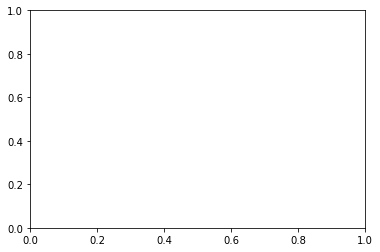

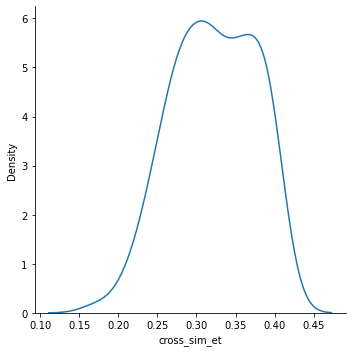

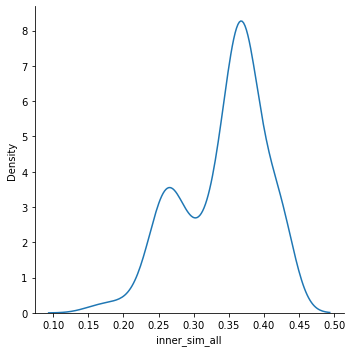

In [127]:
fig, ax = plt.subplots()
sns.displot(train_sims['cross_sim_et'], ax=ax, kind='kde')
sns.displot(train_sims['inner_sim_all'], ax=ax, kind='kde')

In [118]:
def inner_similarity(a):
    inner_sims = []
    for i in range(len(a)):
        out_of_fold = a[:i] + a[i+1:]
        mol_sims = []
        for mol in out_of_fold:
            mol_sims.append(DataStructs.FingerprintSimilarity(mol, a[i]))
        inner_sims.append(np.array(mol_sims))
    return np.array(inner_sims)


def cross_similarity(a, b):
    cross_sims = []
    for a_mol in a:
        mol_sims = []
        for b_mol in b:
            mol_sims.append(DataStructs.FingerprintSimilarity(a_mol, b_mol))
        cross_sims.append(np.array(mol_sims))
        
    return np.array(cross_sims)

In [81]:
train_inner = inner_similarity([x[0] for x in pk_train_fps])
test_inner = inner_similarity([x[0] for x in pk_test_fps])
et_inner = inner_similarity(et_fps)

In [105]:
train_inner.mean(axis=1)

(152,)

In [102]:
import seaborn as sns

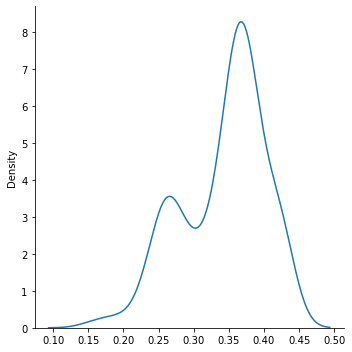

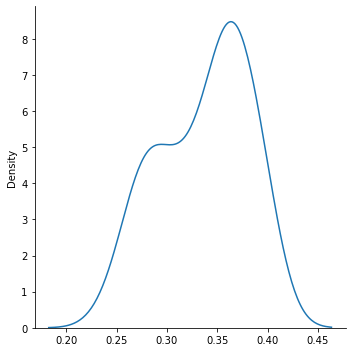

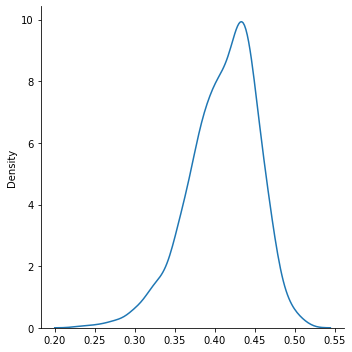

In [110]:
sns.displot(train_inner.mean(axis=1), kind='kde')
sns.displot(test_inner.mean(axis=1), kind='kde')
sns.displot(et_inner.mean(axis=1), kind='kde')

In [97]:
np.mean(train_inner), np.mean(test_inner), np.mean(et_inner)

(0.34268039606365785, 0.3368380714888184, 0.41055776028400703)

In [98]:
cross_train_et = cross_similarity([x[0] for x in pk_train_fps], et_fps)
cross_test_et = cross_similarity([x[0] for x in pk_test_fps], et_fps)
cross_train_test_et = cross_similarity([x[0] for x in pk_train_fps] + [x[0] for x in pk_test_fps], et_fps)

In [ ]:
cross_train_et = cross_similarity([x[0] for x in pk_train_fps], et_fps)
cross_test_et = cross_similarity([x[0] for x in pk_test_fps], et_fps)
cross_train_test_et = cross_similarity([x[0] for x in pk_train_fps] + [x[0] for x in pk_test_fps], et_fps)

In [99]:
np.mean(cross_train_et), np.mean(cross_test_et), np.mean(cross_train_test_et)

(0.32484024875654793, 0.3208281026416174, 0.3243521580687348)

### Analysis of Best Model

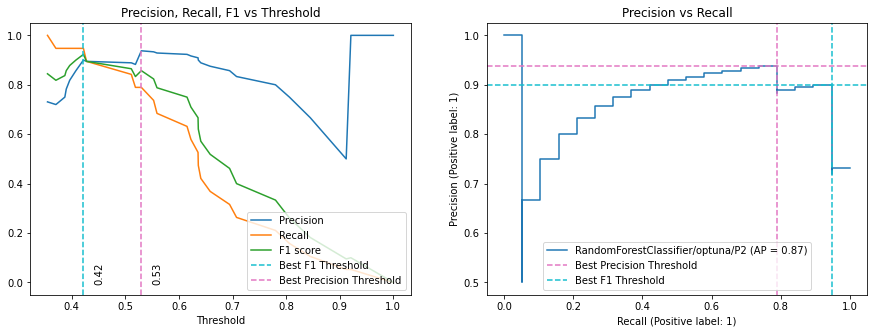

In [37]:
best_model = test_metrics['model'].head(1).values[0]

if 'P1' in best_model:
    pass
    # thresh_values, df_analysis = threshold_analysis(X_tst_p1, y_tst_p1, trained_models[best_model], X_et=X_et_1, clf_name=best_model)
elif 'P2' in best_model:
    thresh_values, df_analysis = threshold_analysis(X_tst_p2, y_tst_p2, trained_models[best_model], X_et=X_et_2, clf_name=best_model)

In [38]:
df_analysis

,Scheme,Threshold,Precision,Recall,F1 Score,Test Acc.,% Active in Test Set,% Active in E.T. (956) Set
0,Best Prec. Thresh.,0.530,0.938,0.789,0.857,0.868,42.105,1.464
1,Best F1 Thresh.,0.422,0.900,0.947,0.923,0.921,52.632,78.870


In [ ]:
[0.01, 0.02, 0.30, 0.45, 0.67, 0.98, 0.99]
0.50 <- best F1 threshold

[0.01, 0.03, 0.07, 0.09, 0.1]

In [ ]:
train - 80%, test - 20%

- train on train set and predict on the external test
- train on train + test set and predict on the external test